In [1]:
import os
import torch
import torchvision as tv
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt

In [2]:
data_dir = 'C:/Users/indir/Machine_learning/Dataset'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['labels.txt', 'test', 'train']
['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [3]:
for i in classes:
    var_files = os.listdir(data_dir + '/train/' + i)
    print(i,': ',len(var_files))

anger :  4462
disgust :  493
fear :  4593
happiness :  8110
neutral :  5572
sadness :  5483
surprise :  3586


In [4]:
dataset = ImageFolder(data_dir + '/train', transform = ToTensor())

In [5]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 32298
    Root location: C:/Users/indir/Machine_learning/Dataset/train
    StandardTransform
Transform: ToTensor()


In [6]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 48, 48]) 0


tensor([[[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.6353],
         ...,
         [0.1412, 0.1490, 0.1451,  ..., 0.4980, 0.5294, 0.5255],
         [0.1490, 0.1529, 0.1647,  ..., 0.4314, 0.4549, 0.4745],
         [0.1529, 0.1569, 0.1647,  ..., 0.4667, 0.5255, 0.5529]],

        [[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.6353],
         ...,
         [0.1412, 0.1490, 0.1451,  ..., 0.4980, 0.5294, 0.5255],
         [0.1490, 0.1529, 0.1647,  ..., 0.4314, 0.4549, 0.4745],
         [0.1529, 0.1569, 0.1647,  ..., 0.4667, 0.5255, 0.5529]],

        [[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.

In [7]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  anger (0)


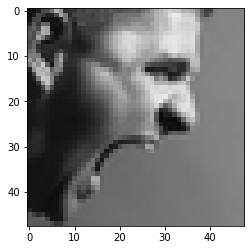

In [8]:
show_example(*dataset[100])

In [9]:
val_size = int(0.1*32298)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset,[train_size, val_size])

test_ds = ImageFolder(data_dir + '/test', transform = ToTensor())

In [10]:
# Hyperparmeters
batch_size = 150

# Other constants
input_size = 3*48*48
num_classes = 7

In [11]:
train_loader = DataLoader(
    train_ds, 
    batch_size, 
    shuffle=True         )

val_loader = DataLoader(
    val_ds, 
    batch_size*2       )

test_loader = DataLoader(
    test_ds, 
    batch_size*2        )

images.shape: torch.Size([150, 3, 48, 48])


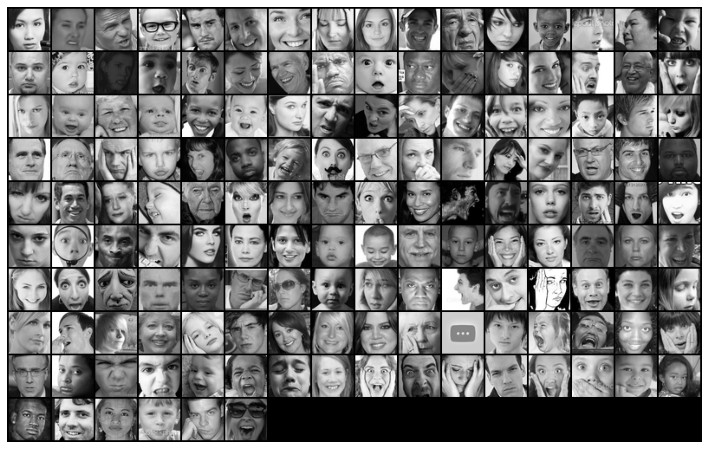

In [12]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [13]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)#else xb.reshape(-1, 3*48*48)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = LogisticRegression()

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = torch.optim.Adam(model.parameters(),lr)
    #optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
evaluate(model, val_loader)

{'val_loss': 1.972868800163269, 'val_acc': 0.13846102356910706}

In [17]:
history = fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 8.5777, val_acc: 0.1767
Epoch [1], val_loss: 6.8590, val_acc: 0.2669
Epoch [2], val_loss: 7.1015, val_acc: 0.1723
Epoch [3], val_loss: 3.7900, val_acc: 0.3037
Epoch [4], val_loss: 2.0529, val_acc: 0.3606
Epoch [5], val_loss: 2.6162, val_acc: 0.3130
Epoch [6], val_loss: 3.3375, val_acc: 0.3571
Epoch [7], val_loss: 4.4605, val_acc: 0.2439
Epoch [8], val_loss: 8.6251, val_acc: 0.2106
Epoch [9], val_loss: 4.3285, val_acc: 0.2260


In [18]:
history += fit(15, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7478, val_acc: 0.3691
Epoch [1], val_loss: 1.7869, val_acc: 0.3601
Epoch [2], val_loss: 1.7910, val_acc: 0.3385
Epoch [3], val_loss: 1.7085, val_acc: 0.3688
Epoch [4], val_loss: 1.7236, val_acc: 0.3599
Epoch [5], val_loss: 1.7127, val_acc: 0.3512
Epoch [6], val_loss: 1.8347, val_acc: 0.3419
Epoch [7], val_loss: 1.6697, val_acc: 0.3643
Epoch [8], val_loss: 1.7366, val_acc: 0.3451
Epoch [9], val_loss: 1.7001, val_acc: 0.3711
Epoch [10], val_loss: 1.6907, val_acc: 0.3684
Epoch [11], val_loss: 1.6974, val_acc: 0.3762
Epoch [12], val_loss: 1.6773, val_acc: 0.3629
Epoch [13], val_loss: 1.7360, val_acc: 0.3520
Epoch [14], val_loss: 1.7638, val_acc: 0.3139


In [19]:
history += fit(20, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6562, val_acc: 0.3732
Epoch [1], val_loss: 1.6468, val_acc: 0.3766
Epoch [2], val_loss: 1.6479, val_acc: 0.3740
Epoch [3], val_loss: 1.6541, val_acc: 0.3614
Epoch [4], val_loss: 1.6487, val_acc: 0.3794
Epoch [5], val_loss: 1.6491, val_acc: 0.3772
Epoch [6], val_loss: 1.6540, val_acc: 0.3746
Epoch [7], val_loss: 1.6838, val_acc: 0.3531
Epoch [8], val_loss: 1.6446, val_acc: 0.3772
Epoch [9], val_loss: 1.6444, val_acc: 0.3820
Epoch [10], val_loss: 1.6411, val_acc: 0.3730
Epoch [11], val_loss: 1.6480, val_acc: 0.3728
Epoch [12], val_loss: 1.6650, val_acc: 0.3639
Epoch [13], val_loss: 1.6639, val_acc: 0.3650
Epoch [14], val_loss: 1.6467, val_acc: 0.3694
Epoch [15], val_loss: 1.6449, val_acc: 0.3736
Epoch [16], val_loss: 1.6440, val_acc: 0.3752
Epoch [17], val_loss: 1.6497, val_acc: 0.3733
Epoch [18], val_loss: 1.6464, val_acc: 0.3727
Epoch [19], val_loss: 1.6593, val_acc: 0.3705


In [20]:
# Lets define a function for plotting graphs
def plot_accuracies(history):
    accuracies = [r['val_acc'] for r in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x', color='red')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs No. of Epoch')

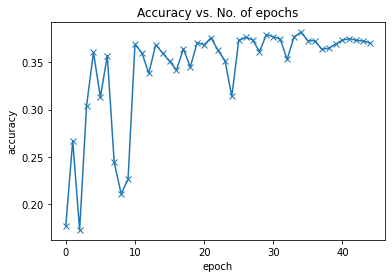

In [21]:
plot_accuracies(history)

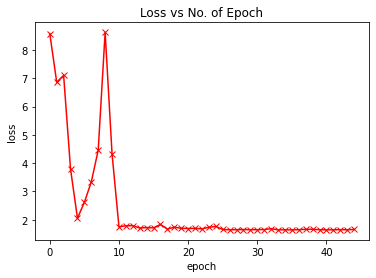

In [22]:
plot_losses(history)

In [23]:
result = evaluate(model, test_loader)

In [24]:
result

{'val_loss': 1.6630393266677856, 'val_acc': 0.3718319833278656}

In [25]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [28]:
y_pred = []
y_true = []

In [29]:
#for batch in train_loader:
#    for i in range(len(test_ds)):
#        inputs, labels = test_ds[i]
#        loss = model.training_step(batch)
#        y_pred.append(loss)
#        y_true.append(labels)
#        cf_matrix = confusion_matrix(y_true, y_pred)
#        df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                         columns = [i for i in classes])
#        plt.figure(figsize = (12,7))
import numpy as np
predicted = np.zeros(shape=(7,7))
#print(predicted)
print(len(test_ds.classes))
for i in range(len(test_ds.classes)):
    print(test_ds.classes[i])
    for j in range(len(test_ds.classes)):
        for k in range(len(test_ds)):
            img, label = test_ds[k]
            if(test_ds.classes[i] == dataset.classes[predict_image(img, model)]):
                predicted[i][i] += 1

print(predicted)

7
anger
disgust
fear
happiness
neutral
sadness
surprise
[[4165.    0.    0.    0.    0.    0.    0.]
 [   0.  105.    0.    0.    0.    0.    0.]
 [   0.    0. 2653.    0.    0.    0.    0.]
 [   0.    0.    0. 7882.    0.    0.    0.]
 [   0.    0.    0.    0. 5558.    0.    0.]
 [   0.    0.    0.    0.    0. 1288.    0.]
 [   0.    0.    0.    0.    0.    0. 3472.]]


In [ ]:
indexes = []
anger = []
disgust = []
fear = []
happiness = []
neutral = []
sadness = []
surprise = []
for i in range(len(test_ds)):
    img, label = test_ds[i]
    if(test_ds.classes[label] == dataset.classes[predict_image(img, model)]):
        indexes.append(i)
    if (test_ds.classes[label] == 'anger' and test_ds.classes[label] == dataset.classes[predict_image(img, model)]):
        anger.append(i)
    elif (test_ds.classes[label] == 'disgust' and test_ds.classes[label] == dataset.classes[predict_image(img, model)]):
        disgust.append(i)
    elif (test_ds.classes[label] == 'fear' and test_ds.classes[label] == dataset.classes[predict_image(img, model)]):
        fear.append(i)
    elif (test_ds.classes[label] == 'happiness' and test_ds.classes[label] == dataset.classes[predict_image(img, model)]):
        happiness.append(i)
    elif (test_ds.classes[label] == 'neutral' and test_ds.classes[label] == dataset.classes[predict_image(img, model)]):
        neutral.append(i)
    elif (test_ds.classes[label] == 'sadness' and test_ds.classes[label] == dataset.classes[predict_image(img, model)]):
        sadness.append(i)
    elif (test_ds.classes[label] == 'surprise' and test_ds.classes[label] == dataset.classes[predict_image(img, model)]):
        surprise.append(i)
#print(indexes)
#len(test_ds)
#print(disgust)

In [ ]:
print("Anger: ", len(anger)/len(indexes))
print("Disgust: ", len(disgust)/len(indexes))
print("Fear: ", len(fear)/len(indexes))
print("Happiness: ", len(happiness)/len(indexes))
print("Neutral: ", len(neutral)/len(indexes))
print("Sadness: ", len(sadness)/len(indexes))
print("Surprise: ", len(surprise)/len(indexes))

In [ ]:
img, label = test_ds[1300]
plt.imshow(img[0], cmap='gray')
print('Label:', test_ds.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [ ]:
img, label = test_ds[3006]
plt.imshow(img[0], cmap='gray')
print('Label:', test_ds.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [ ]:
img, label = test_ds[181]
plt.imshow(img[0], cmap='gray')
print('Label:', test_ds.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [ ]:
img, label = test_ds[1999]
plt.imshow(img[0], cmap='gray')
print('Label:', test_ds.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [ ]:
img, label = test_ds[549]
plt.imshow(img[0], cmap='gray')
print('Label:', test_ds.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [ ]:
img, label = test_ds[3173]
plt.imshow(img[0], cmap='gray')
print('Label:', test_ds.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Like all regression analyses, the logistic regression is a predictive analysis.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem. Its basic fundamental concepts are also constructive in deep learning. Logistic regression describes and estimates the relationship between one dependent binary variable and independent variables.

Logistic regression is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes.

Advantages
Because of its efficient and straightforward nature, doesn't require high computation power, easy to implement, easily interpretable, used widely by data analyst and scientist. Also, it doesn't require scaling of features. Logistic regression provides a probability score for observations.

Disadvantages
Logistic regression is not able to handle a large number of categorical features/variables. It is vulnerable to overfitting. Also, can't solve the non-linear problem with the logistic regression that is why it requires a transformation of non-linear features.